# Import Packages and Load Data

In [1]:
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm

sys.path.append('../../bitome2')

from bitome.core import Bitome

In [2]:
K12_DATA_PATH = Path('../data/bitome2/mg1655')

In [3]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [4]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    # TODO PARSE TTS data
    tts_table=None,
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

In [5]:
snp_df = pd.read_csv('snp_df.csv', index_col=0)
snp_df.head()

,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism
49,42C,1,124,1,1,1.0,NC_000913,1308318,SNP,R110G (CGT→GGT),G→C,clsA,True,Escherichia coli
161,42C,1,124,1,1,1.0,NC_000913,4187550,SNP,A734V (GCG→GTG),C→T,rpoC,True,Escherichia coli
13,42C,1,124,1,1,1.0,NC_000913,4400313,SNP,D9A (GAT→GCT),A→C,hfq,True,Escherichia coli
18,42C,2,163,1,1,1.0,NC_000913,149214,SNP,A130T (GCC→ACC),C→T,panB,True,Escherichia coli
128,42C,2,163,1,1,1.0,NC_000913,219624,SNP,C124C (TGT→TGC),A→G,rcsF,True,Escherichia coli


# Filter By Reference Sequence

We want to be absolutely sure that we are talking about the same reference sequence, so let's take a quick look at the different options and select only the ones for MG1655 (NC_000913)

In [6]:
snp_df['Reference Seq'].value_counts()

NC_000913    49755
.              818
Name: Reference Seq, dtype: int64

Okay let's get rid of these weird ones with "." as the reference sequence, not sure what that is but I don't like it

In [7]:
mg1655_snp_df = snp_df[snp_df['Reference Seq'] == 'NC_000913']

# Get All Noncoding Positions

In [8]:
# get the locations of all genes as a sorted list, each in the form (left, right)
sorted_gene_lrs = sorted(list(zip(mg1655.gene_table.left, mg1655.gene_table.right)))

# prepare an empty list to hold our noncoding positions
noncoding_positions = []

# start with pos set to 1; we are assuming (correctly) there is no gene here
last_pos = 1

# iterate through the gene locations; use an index so we can look backwards if necessary
# tqdm gives us a progress bar
for gene_l, gene_r in tqdm(sorted_gene_lrs):
    
    # we have some genes that overlap; if the last pos is actually greater than or equal to
    # the current gene's left (i.e. the last gene we looked at ends after this current one begins)
    # we can simply update the last_pos to be the rightmost between last_pos and gene_r
    if last_pos >= gene_l:
        last_pos = max(last_pos, gene_r)
    # otherwise, there was an intergenic region (no overlap between genes)
    else:
        # everything from the last pos to the gene left (NOT including gene left) is non-coding
        noncoding_positions += list(range(last_pos, gene_l))
        # reset the last pos to be one after the right of the gene
        last_pos = gene_r + 1
        
# print the length and % length of noncoding; this should be ~10%
print(f'{len(noncoding_positions)} noncoding positions found')
print(f'{len(noncoding_positions)/len(mg1655.sequence)*100:.2f}% noncoding')


504262 noncoding positions found
10.86% noncoding


Okay so this makes sense; now we have a giant list of all the non-coding positions, we can filter the SNP DF

# Filter SNP DataFrame

In [9]:
# we simply want to take any row of the SNP DataFrame where the position is in our list of noncoding positions
noncoding_snp_df = mg1655_snp_df[mg1655_snp_df['Position'].isin(noncoding_positions)]
noncoding_snp_df

,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism
136,42C,2,163,1,1,1.0,NC_000913,703652,SNP,intergenic (‑41/‑292),A→G,nagB/nagE,False,Escherichia coli
155,42C,2,163,1,1,1.0,NC_000913,3346530,SNP,intergenic (+70/‑48),C→A,hpf/ptsN,False,Escherichia coli
110,42C,3,120,1,1,1.0,NC_000913,1755639,SNP,intergenic (‑498/‑59),G→A,ydhZ/pykF,False,Escherichia coli
115,42C,3,120,1,1,1.0,NC_000913,2731312,SNP,intergenic (‑155/+288),G→A,rrsG/clpB,False,Escherichia coli
77,42C,4,161,1,1,1.0,NC_000913,1115627,SNP,intergenic (‑137/+35),C→T,mdtG/lpxL,False,Escherichia coli
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22,tpiKO,6,8,1,1,1.0,NC_000913,3088193,SNP,intergenic (+333/‑91),C→A,metK/galP,False,Escherichia coli
4,tpiKO,7,28,1,1,1.0,NC_000913,1420279,SNP,intergenic (‑38/‑86),C→A,racR/ydaS,False,Escherichia coli
22,tpiKO,7,28,1,1,1.0,NC_000913,3088193,SNP,intergenic (+333/‑91),C→A,metK/galP,False,Escherichia coli
90,tpiKO,10,28,1,1,1.0,NC_000913,3088191,SNP,intergenic (+333/‑91),C→A,metK/galP,False,Escherichia coli


This looks great, because in the Details column, we see all intergenic! Realizing I could have just used that to filter...but now we know that Patrick's pipeline correctly annotated those as intergenic. It actually also gives us the distances to each of the genes on each side, which may be useful later, but we can calculate those ourselves too. 

And this is awesome because there are still 6457 non-coding SNPs to work with. 

# Save Noncoding SNP DataFrame

Now that we have this DataFrame, save it so future workflows can start from a well-established non-coding SNP dataset. 

In [10]:
noncoding_snp_df.to_csv('noncoding_snp_df.csv')

# Look for SNPs in Core Promoter (Example)

Let's say we're interested in SNPs that occur within the core promoter, which we'll define as:

-50 to +10 from the TSS

We can work through the TU table to find mutations in this range (note we're NOT using the features_in_range function)

In [11]:
tu_table_with_tss = mg1655.tu_table[mg1655.tu_table['tss'].notna()]

prom_snp_dfs = []

for tu_row in tu_table_with_tss.itertuples():
    
    # determine the core promoter position range; careful for strand!
    tss = tu_row.tss
    strand = tu_row.strand
    if strand == 1:
        promoter_l, promoter_r = tss - 50, tss + 10
    else:
        promoter_l, promoter_r = tss - 10, tss + 50

    # look for noncoding SNPs in this range; can't do blah < x < blah2 in Pandas syntax unfortunately
    nc_snps_in_prom_df = noncoding_snp_df[
        (promoter_l <= noncoding_snp_df['Position']) & 
        (promoter_r >= noncoding_snp_df['Position'])
    ]
    
    # if this wasn't empty, cool! we have a promoter mutation! accumulate these into a new dataframe
    if not nc_snps_in_prom_df.empty:
        nc_snps_in_prom_df = nc_snps_in_prom_df.copy()
        # add the TSS information and the distance to TSS of the mutations
        nc_snps_in_prom_df['tss'] = tss
        nc_snps_in_prom_df['tu_id'] = tu_row.Index
        nc_snps_in_prom_df['dist_to_tss'] = (nc_snps_in_prom_df['Position'] - nc_snps_in_prom_df['tss']) * strand
        prom_snp_dfs.append(nc_snps_in_prom_df)
        
prom_snp_df = pd.concat(prom_snp_dfs)
prom_snp_df

,exp,ale,flask,isolate,tech_rep,presence,Reference Seq,Position,Mutation Type,Details,Sequence Change,Gene,coding,organism,tss,tu_id,dist_to_tss
109,TOL_hexamethylenediamine,4,50,3,1,1.00,NC_000913,940856,SNP,intergenic (+136/‑103),A→G,serS/dmsA,False,Escherichia coli,940878.0,ECK120008921,-22.0
236,EEP_ndh_nuoB,6,34,0,1,0.25,NC_000913,1157629,SNP,intergenic (+55/‑240),G→C,ycfH/ptsG,False,Escherichia coli,1157626.0,ECK120008924,3.0
0,EEP_ndh_nuoB,6,34,0,1,0.25,NC_000913,1157632,SNP,intergenic (+58/‑237),A→T,ycfH/ptsG,False,Escherichia coli,1157626.0,ECK120008924,6.0
256,EEP_ndh_nuoB,6,34,0,1,0.25,NC_000913,1157633,SNP,intergenic (+59/‑236),A→T,ycfH/ptsG,False,Escherichia coli,1157626.0,ECK120008924,7.0
208,EEP_ndh_nuoB,6,34,0,1,0.23,NC_000913,1157636,SNP,intergenic (+62/‑233),G→C,ycfH/ptsG,False,Escherichia coli,1157626.0,ECK120008924,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,BOP27-M9-NC_000913_3gb-log-37-Glucose2-NH4Cl1-...,7,422,53,1,1.00,NC_000913,2966116,SNP,intergenic (‑79/+72),A→C,lgt/ptsP,False,Escherichia coli,2966121.0,ECK125230242,5.0
340,HOT_dnaQ,12,56,1,1,1.00,NC_000913,1105806,SNP,intergenic (+81/‑14),T→C,ymdA/ymdB,False,Escherichia coli,1105803.0,ECK125257178,3.0
10,SSW_GLU_AC,8,91,7,1,1.00,NC_000913,4073641,SNP,intergenic (‑70/‑98),C→A,yihU/yihV,False,Escherichia coli,4073596.0,ECK125285341,-45.0
10,SSW_GLU_AC,8,91,7,1,1.00,NC_000913,4073641,SNP,intergenic (‑70/‑98),C→A,yihU/yihV,False,Escherichia coli,4073634.0,ECK125285342,-7.0


So we have 1065 SNPs in the core promoter region, that's cool! 

Note that some SNPs are repeated, because sometimes TSS are close to each other, so the SNP will be in 3 different core promoters that are slightly offset. This is fine though. 

Let's quickly plot a histogram of where they are distance-wise.

<AxesSubplot:xlabel='dist_to_tss', ylabel='Count'>

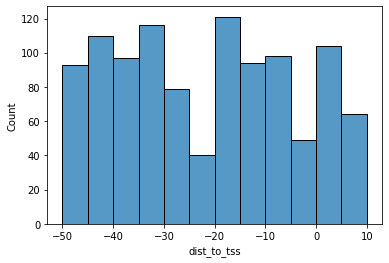

In [12]:
sns.histplot(x='dist_to_tss', data=prom_snp_df)